In [39]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, mean_absolute_error, r2_score

In [40]:
# path = '/content/content/MyDrive/[ML DL] data/[Dacon]전력사용량 예측 AI 경진대회/'
path = './data/'

# train = pd.read_csv(path + 'Train_for_model.csv', encoding='utf-8')
# train['date_time'] = pd.to_datetime(train['date_time'])
# test = pd.read_csv(path + 'Test_for_model.csv', encoding='utf-8')
# test['date_time'] = pd.to_datetime(test['date_time'])

train = pd.read_csv(path + 'train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv(path + 'test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])


# test = test.interpolate()
test = test.interpolate(method='polynomial', order=2)
test = test.interpolate()

In [41]:
train_col_name = ['num', 'date_time', 'y', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']
test_col_name = ['num', 'date_time', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']

train = pd.DataFrame(train.values, columns=train_col_name)
test = pd.DataFrame(test.values, columns=test_col_name)

## Preprocessing

In [42]:
train[['num', 'cold_system','sun_system']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'cold_system']
    hot[count]=train.loc[i,'sun_system']

for i in range(len(test)):
    test.loc[i, 'cold_system']=ice[test['num'][i]]
    test.loc[i, 'sun_system']=hot[test['num'][i]]

In [43]:
def get_pow(series):
    return math.pow(series, 0.15)

def holiday(x):
    if x.weekday() == 5 or x.weekday() == 6:
        return 1
    elif str(x.date()) == '2020-08-17':
        return 1
    else: 
        return 0

def preprocessing(df):
    df['month'] = df.date_time.apply(lambda x: x.month)
    df['weekday'] = df.date_time.apply(lambda x: x.weekday())
    df['hour'] = df.date_time.apply(lambda x: int(str(x.time())[:2]))
    df['holiday'] = df['date_time'].apply(lambda x: holiday(x))
    df.loc[df['wind'] <= 0, 'wind'] = 0
    df.loc[df['rain'] <= 0, 'rain'] = 0
    df.loc[df['sun'] <= 0, 'sun'] = 0
    df['perceived_temperature'] = 13.12 + 0.6215*df['temp'] - 11.37*df['wind'].apply(get_pow) + 0.3965*df['wind'].apply(get_pow)*df['temp']
    df['discomfort_index'] = 1.8*df['temp'] - 0.55*(1-df['humidity']/100)*(1.8*df['temp']-26) + 32
    # df['discomfort_index'] = pd.cut(df['discomfort_index'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
    df['monday'] = df['weekday'].apply(lambda x: 1 if x == 0 else 0)
    df.loc[:, 'rain'] = df.loc[:, 'rain'].apply(lambda x: 0 if x == 0 else 1)
    return df

In [44]:
# type_columns = ['temp', 'wind', 'humidity', 'rain', 'sun']

# for i in type_columns:
#     train[i] = train[i].astype('float64')
#     test[i] = test[i].astype('float64')

In [45]:
train = preprocessing(train)
test = preprocessing(test)

In [46]:
idx_31 = train[(train['num'] == 31) & (train['date_time'] == '2020-06-11 17:00:00')].index
idx_33 = train[(train['num'] == 33) & (train['date_time'] == '2020-06-11 17:00:00')].index
idx_36 = train[(train['num'] == 36) & ((train['date_time'] == '2020-08-19 05:00:00') |
                                        (train['date_time'] == '2020-08-19 06:00:00') |
                                        (train['date_time'] == '2020-08-19 07:00:00') |
                                        (train['date_time'] == '2020-08-19 08:00:00') |
                                        (train['date_time'] == '2020-08-19 09:00:00'))].index
idx_45 = train[(train['num'] == 45) & (train['date_time'] == '2020-07-05 01:00:00')].index

In [47]:
train = train.drop(idx_31, axis=0)
train = train.drop(idx_33, axis=0)
train = train.drop(idx_36, axis=0)
train = train.drop(idx_45, axis=0)

## Clustering

In [ ]:
# min_max_scaling
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'y'] = ((train.loc[train.num == i, 'y']) - mean_) / std_

In [ ]:
# 요일에 따른 평균 값 산출
weekday_mean = (
    train.groupby(['num', 'weekday'])['y'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'y')
    .reset_index()
)

In [ ]:
# 시간에 따른 평균 값 산출
hour_mean = (
    train.groupby(['num', 'hour'])['y'].mean()
    .reset_index()
    .pivot('num', 'hour', 'y')
    .reset_index()
    .drop('num', axis=1)
)

In [ ]:
# 요일별, 시간별 평균 전력 사용량 테이블 구축
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [ ]:
def cluster_evaluate(cluster_df, n_cluster, columns):
#     dic = {}
    inertia_arr = []
    cluster_df = cluster_df[columns]

    for c in n_cluster:
        
        kmeans = KMeans(n_clusters=c, init='k-means++', random_state=0)
        kmeans.fit(cluster_df)
        
        interia = kmeans.inertia_
        inertia_arr.append(interia)
        
        pred_cluster = kmeans.predict(cluster_df)
        cluster_df['cluster_label'] = pred_cluster

        score_samples = silhouette_samples(cluster_df, cluster_df['cluster_label'])
        cluster_df['silhouette_coeff'] = score_samples

        mean_score = silhouette_score(cluster_df, cluster_df['cluster_label'])
        print('n_cluster: {}\nSilhouette: {:.4f}'.format(c, mean_score))
        
#         dic['kmeans'+str(c)] = df
    plt.figure(figsize=(10, 5))
    plt.plot(n_cluster, inertia_arr)
    plt.title('Elbow Method')
    plt.xlabel('k')
    plt.ylabel('inertia')
    
    plt.show()
    
    return cluster_df

In [ ]:
columns = ['temp', 'wind', 'humidity', 'rain', 'sun', 'perceived_temperature', 'discomfort_index']
knn_n_cluster = [4, 6, 8, 10]

clusters = cluster_evaluate(train, knn_n_cluster, columns)

In [63]:
columns = ['temp', 'wind', 'humidity', 'rain', 'sun', 'perceived_temperature', 'discomfort_index']

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=37)
kmeans.fit(train[columns])

train_cluster = kmeans.predict(train[columns])
test_cluster = kmeans.predict(test[columns])

print(train_cluster.shape)
print(test_cluster.shape)

print(train.shape)
print(test.shape)

(122392,)
(10080,)
(122392, 17)
(10080, 16)


In [64]:
train['weather_cluster'] = train_cluster
test['weather_cluster'] = test_cluster

train['y'] = train['y'].astype('float32')

In [ ]:
# cluster_0 = train.groupby(['weather_cluster', 'hour']).mean().loc[0, :]['y']
# cluster_1 = train.groupby(['weather_cluster', 'hour']).mean().loc[1, :]['y']
# cluster_2 = train.groupby(['weather_cluster', 'hour']).mean().loc[2, :]['y']
# cluster_3 = train.groupby(['weather_cluster', 'hour']).mean().loc[3, :]['y']
# cluster_4 = train.groupby(['weather_cluster', 'hour']).mean().loc[4, :]['y']
# cluster_5 = train.groupby(['weather_cluster', 'hour']).mean().loc[5, :]['y']
# cluster_6 = train.groupby(['weather_cluster', 'hour']).mean().loc[6, :]['y']
# cluster_7 = train.groupby(['weather_cluster', 'hour']).mean().loc[7, :]['y']

# fig = go.Figure()

# fig.add_trace(go.Scatter(x=cluster_0.index, y=cluster_0, name='assignment_0'))
# fig.add_trace(go.Scatter(x=cluster_1.index, y=cluster_1, name='assignment_1'))
# fig.add_trace(go.Scatter(x=cluster_2.index, y=cluster_2, name='assignment_2'))
# fig.add_trace(go.Scatter(x=cluster_3.index, y=cluster_3, name='assignment_3'))
# fig.add_trace(go.Scatter(x=cluster_4.index, y=cluster_4, name='assignment_4'))
# fig.add_trace(go.Scatter(x=cluster_5.index, y=cluster_5, name='assignment_5'))
# fig.add_trace(go.Scatter(x=cluster_6.index, y=cluster_6, name='assignment_6'))
# fig.add_trace(go.Scatter(x=cluster_7.index, y=cluster_7, name='assignment_7'))

# fig.update_layout(title='군집별',
#                   yaxis_title='전력사용량(kWh)')
# fig.show()

In [13]:
# #군집별 가중치 부여

# lst = []
# p_lst = []

# for i in range(5):
#     m = train[(train['num'] == 37) & (train['cluster'] == i)]['y'].mean()
#     lst.append(m)

# for i in range(5):
#     p = train[(train['num'] == 37) & (train['cluster'] == i)]['y'].mean() / np.sum(lst)
#     p_lst.append(p)

# train['cluster_weight'] = train.cluster.apply(lambda x: p_lst[x])
# test['cluster_weight'] = test.cluster.apply(lambda x: p_lst[x])

## Train Test Split

In [48]:
def feature_label_split(df):
    y = df['y']
    X = df.drop(['date_time', 'y'], axis = 1).reset_index(drop=True)
    y = y.astype('float32')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['num'], random_state=37)
    
    return X_train, X_test, y_train, y_test

In [49]:
X_train, X_test, y_train, y_test = feature_label_split(train)

In [50]:
test = test.drop('date_time', axis=1)

In [51]:
# def data_scaler(train_data, test_data, test):
#     scaler = StandardScaler()
#     scaler.fit(train_data.drop('num', axis=1))
#     X = scaler.transform(train_data.drop('num', axis=1))
#     X_test = scaler.transform(test_data.drop('num', axis=1))
#     scaled_test = scaler.transform(test.drop('num', axis=1))
    
#     col_name = ['temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system', 'month', 'weekday', 'hour', 'holiday',
#                 'perceived_temperature', 'discomfort_index', 'monday']
    
#     X = pd.DataFrame(X, columns=col_name)
#     X_test = pd.DataFrame(X_test, columns=col_name)
#     scaled_test = pd.DataFrame(scaled_test, columns=col_name)
    

#     num_train = pd.DataFrame(train_data.num.values, columns=['num'])
#     num_test = pd.DataFrame(test_data.num.values, columns=['num'])
#     num_t = pd.DataFrame(test.num.values, columns=['num'])
    
    
#     num_train = num_train.astype('int')
#     num_test = num_test.astype('int')
#     num_t = num_t.astype('int')
    
#     X = pd.concat([X, num_train], axis=1)
#     X_test = pd.concat([X_test, num_test], axis=1)
#     test = pd.concat([scaled_test, num_t], axis=1)

#     return X, X_test, test

In [52]:
def num_data_scaler(train_data, test_data, test):
    scaler = StandardScaler()
    scaler.fit(train_data.drop(['num', 'weekday'], axis=1))
    X = scaler.transform(train_data.drop(['num', 'weekday'], axis=1))
    X_test = scaler.transform(test_data.drop(['num', 'weekday'], axis=1))
    scaled_test = scaler.transform(test.drop(['num', 'weekday'], axis=1))
    
    col_name = ['temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system', 'month', 'hour', 'holiday',
                'perceived_temperature', 'discomfort_index', 'monday']
    
    X = pd.DataFrame(X, columns=col_name)
    X_test = pd.DataFrame(X_test, columns=col_name)
    scaled_test = pd.DataFrame(scaled_test, columns=col_name)
    

    num_train = train_data[['num', 'weekday']].astype('int')
    num_test = test_data[['num', 'weekday']].astype('int')
    num_t = test[['num', 'weekday']].astype('int')

    
    X = pd.concat([X, num_train], axis=1)
    X_test = pd.concat([X_test, num_test], axis=1)
    test = pd.concat([scaled_test, num_t], axis=1)

    return X, X_test, test

In [53]:
X_train, X_test, test = num_data_scaler(X_train, X_test, test)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [54]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*200

## Modeling

In [55]:
def num_evaluate(X_train, y_train, X_test):
    models = {}
    
    for n in X_train.num.unique():
        num_X_train = X_train[X_train['num'] == n]
        num_X_test = X_test[X_test['num'] == n]
        
        train_idx = num_X_train.index
        test_idx = num_X_test.index

        num_y_train = y_train[train_idx]
        num_y_test =  y_test[test_idx]

        print(num_X_train.shape)
        print(num_X_test.shape)
        print(num_y_train.shape)
        print(num_y_test.shape)

        model = RandomForestRegressor(random_state=37)
        model.fit(num_X_train, num_y_train)
        pred = model.predict(num_X_test)
        
        print(f'\n==== NUM: {n} ====\nSMAPE: {SMAPE(np.array(num_y_test), pred):.4f}\n')
        
        models[n] = model

        # sfk = StratifiedKFold(n_splits = n_fold, random_state=37)
        # fold = 1

    #     for tr_idx, val_idx in sfk.split(num_X_train, num_X_train['weekday']):
    #         print('======== {}fold ========'.format(fold))
    #         feature_train = num_X_train.iloc[tr_idx, :]
    #         label_train = num_y_train[tr_idx]

    #         feature_val = num_X_train.iloc[val_idx, :]
    #         label_val = num_y_train[val_idx]
            
    #         model.fit(feature_train, label_train)
    #         pred = model.predict(num_X_test)
            
    #         y_pred += pred / n_fold
            
    #         models[f'{n}_{fold}'] = model
            
    #         print(f'''\nMSE: {mean_squared_error(pred, y_test):.4f}
    # MAE: {mean_absolute_error(pred, y_test):.4f}
    # RMSE: {np.sqrt(mean_squared_error(pred, y_test)):.4f}
    # SMAPE: {SMAPE(np.array(y_test), pred):.4f}\n''')
    #         fold += 1

    return models

In [60]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(117496, 15)
(44063, 15)
(97913,)


In [36]:
# model = RandomForestRegressor(random_state=37)
num_rf_models = num_evaluate(X_train, y_train, X_test)

(1632, 15)
(408, 15)
(1632,)
(408,)

==== NUM: 1.0 ====
SMAPE: 54.8034

(0, 15)
(0, 15)
(0,)
(0,)


ValueError: Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required.

In [18]:
def evaluate(X_train, y_train, X_test, model, n_fold):
    sfk = StratifiedKFold(n_splits = n_fold, random_state=37)
    models = {}
    
    y_pred = np.zeros(len(X_test))
    fold = 1

    for tr_idx, val_idx in sfk.split(X_train, X_train['num']):
        print('======== {}fold ========'.format(fold))
        feature_train = X_train.iloc[tr_idx, :]
        label_train = y_train[tr_idx]

        feature_val = X_train.iloc[val_idx, :]
        label_val = y_train[val_idx]
        
        model.fit(feature_train, label_train)
        pred = model.predict(X_test)
        
        y_pred += pred / n_fold
        
        models[fold] = model
        
        print(f'''\nMSE: {mean_squared_error(pred, y_test):.4f}
MAE: {mean_absolute_error(pred, y_test):.4f}
RMSE: {np.sqrt(mean_squared_error(pred, y_test)):.4f}
SMAPE: {SMAPE(np.array(y_test), pred):.4f}\n''')

        fold += 1
    plt.figure(figsize=(15,5))
    plt.plot(y_test, 'k' ,label='True')
    plt.plot(y_pred, '--g' ,label='Pred')
    plt.title(f'\nSMAPE: {SMAPE(np.array(y_test), y_pred):.4f}\nR2_score: {r2_score(y_pred, y_test):.4f}\n')
    plt.legend()
    plt.show()
    
    return models

In [ ]:
# 4.38

======== 1fold ========

MSE: 27893.2871
MAE: 86.2690
RMSE: 167.0128
SMAPE: 4.4654

======== 2fold ========

MSE: 28448.9553
MAE: 86.5563
RMSE: 168.6682
SMAPE: 4.4769

======== 3fold ========

MSE: 28524.8334
MAE: 86.5260
RMSE: 168.8930
SMAPE: 4.4728

======== 4fold ========

MSE: 28246.3676
MAE: 86.2655
RMSE: 168.0666
SMAPE: 4.4737

======== 5fold ========

MSE: 28095.5275
MAE: 86.3901
RMSE: 167.6172
SMAPE: 4.4711

======== 6fold ========

MSE: 28567.4204
MAE: 86.4456
RMSE: 169.0190
SMAPE: 4.4821

======== 7fold ========

MSE: 28528.1673
MAE: 86.6618
RMSE: 168.9028
SMAPE: 4.4759

======== 8fold ========

MSE: 28093.7915
MAE: 86.4926
RMSE: 167.6120
SMAPE: 4.4649

======== 9fold ========

MSE: 28671.4847
MAE: 86.6568
RMSE: 169.3266
SMAPE: 4.4730

======== 10fold ========

MSE: 28417.0194
MAE: 86.7366
RMSE: 168.5735
SMAPE: 4.4932



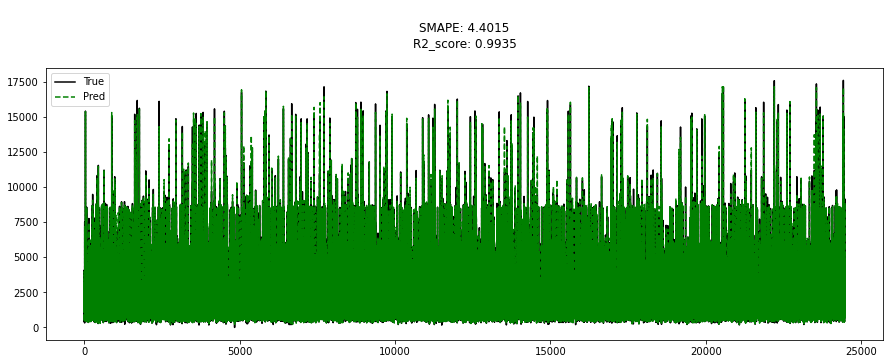

In [19]:
model = RandomForestRegressor(random_state=37)
rf_models = evaluate(X_train, y_train, X_test, model, 10)

======== 1fold ========
Training until validation scores don't improve for 30 rounds
[1000]	valid_0's l1: 256.001
[2000]	valid_0's l1: 192.726
[3000]	valid_0's l1: 169.436
[4000]	valid_0's l1: 151.608
[5000]	valid_0's l1: 144.115
[6000]	valid_0's l1: 137.575
[7000]	valid_0's l1: 133.489
[8000]	valid_0's l1: 130.067
[9000]	valid_0's l1: 126.885
[10000]	valid_0's l1: 125.418
Early stopping, best iteration is:
[10836]	valid_0's l1: 124.567

MSE: 54604.1717
MAE: 123.7567
RMSE: 233.6754
SMAPE: 6.3097

======== 2fold ========
Training until validation scores don't improve for 30 rounds
[1000]	valid_0's l1: 260.768
[2000]	valid_0's l1: 191.884
[3000]	valid_0's l1: 168.194
[4000]	valid_0's l1: 152.815
[5000]	valid_0's l1: 143.478
[6000]	valid_0's l1: 134.68
[7000]	valid_0's l1: 131.117
[8000]	valid_0's l1: 128.441
[9000]	valid_0's l1: 127.108
[10000]	valid_0's l1: 125.792
[11000]	valid_0's l1: 124.583
Early stopping, best iteration is:
[11323]	valid_0's l1: 124.284

MSE: 54370.0539
MAE: 124.72

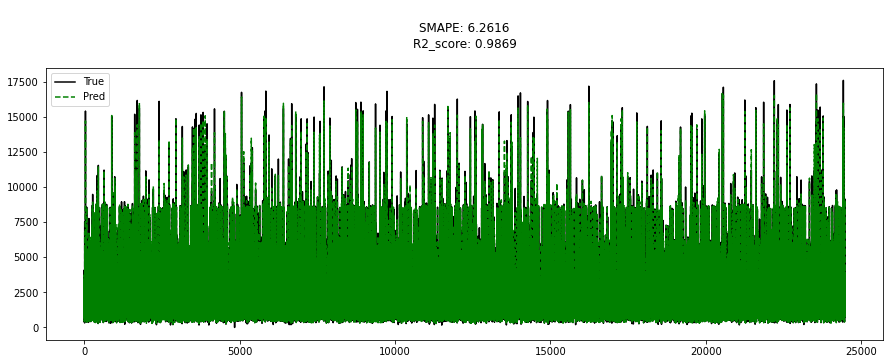

In [87]:
n_splits = 10
sfk = StratifiedKFold(n_splits = n_splits, random_state=37)
lgbm_models = {}

y_pred = np.zeros(len(X_test))
fold = 1

for tr_idx, val_idx in sfk.split(X_train, X_train['num']):
    print('======== {}fold ========'.format(fold))
    feature_train = X_train.iloc[tr_idx, :]
    label_train = y_train[tr_idx]

    feature_val = X_train.iloc[val_idx, :]
    label_val = y_train[val_idx]
    
    lgbm = LGBMRegressor(n_estimators = 20000, learning_rate= 0.01,objective = 'mae', random_state=37)
    lgbm.fit(feature_train, label_train, eval_set=[(feature_val, label_val)], eval_metric= 'mae', early_stopping_rounds=30, verbose=1000)
    pred = lgbm.predict(X_test)
    y_pred += pred / n_splits

    lgbm_models[fold] = lgbm

    print(f'''\nMSE: {mean_squared_error(pred, y_test):.4f}
MAE: {mean_absolute_error(pred, y_test):.4f}
RMSE: {np.sqrt(mean_squared_error(pred, y_test)):.4f}
SMAPE: {SMAPE(np.array(y_test), pred):.4f}\n''')

    fold += 1
    
plt.figure(figsize=(15,5))
plt.plot(y_test, 'k' ,label='True')
plt.plot(y_pred, '--g' ,label='Pred')
plt.title(f'\nSMAPE: {SMAPE(np.array(y_test), y_pred):.4f}\nR2_score: {r2_score(y_pred, y_test):.4f}\n')
plt.legend()
plt.show()

In [88]:
rf_array = np.zeros(len(test))
for i in range(1, 11):
    rf_array += rf_models[i].predict(test)/10
    

lgbm_array = np.zeros(len(test))
for i in range(1, 11):
    lgbm_array += lgbm_models[i].predict(test)/10

In [89]:
total_array = (rf_array *  0.8) + (lgbm_array * 0.2)

In [90]:
submission=pd.read_csv(path + 'sample_submission.csv')
submission['answer'] = total_array
submission.to_csv('rf_0.8_lgbm_0.2_interpolationchange_submission.csv', index=False)